In [1]:
import sys
sys.path.append('./qdarts')

from qdarts.experiment import Experiment
from qdarts.plotting import plot_polytopes

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import utilities.config as c
import utilities.utils  as u
import utilities.model_utils  as mu

import torch

### Looking at the data

<PIL.Image.Image image mode=RGBA size=96x96 at 0x1A6BE9CE220>
C_DD matrix:
[[15.79561717  0.8659954 ]
 [ 0.8659954   9.44310219]]

C_DG matrix:
[[13.85804455  1.07157722]
 [ 1.10839793  7.46870886]]


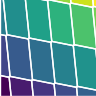

In [6]:
if c.PATH_0 == './ALICE/':
    batch_number = 2
    img_number = '0035487789'
else:
    batch_number = 3
    img_number = '0060485230'

u.reconstruct_img_with_matrices(batch_number, img_number, True)[0]

### Data preprocessing

In [7]:
# datapoints = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'])
datapoints = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'], all_batches=False, batches=np.arange(2,3))

print(f"The amount of datapoints loaded: {len(datapoints)}.")
print(f"The shape of CSD {datapoints[0][0].shape}, and its type {type(datapoints[0][0])}.")

The amount of datapoints loaded: 500.
The shape of CSD (4, 96, 96), and its type <class 'numpy.ndarray'>.


#### Reconstructed image from saved np.ndarray

In [8]:
example = datapoints[19] # 67, 19

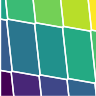

In [9]:
example_csd = example[0]
u.reconstruct_img_from_tensor(example_csd)

#### The preprocessed input seen by the model

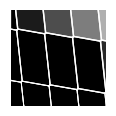

In [11]:
%matplotlib inline

tensor = mu.preprocess_csd(example_csd)
mu.show_image_from_tensor(tensor)

#### Output preproccess

In [12]:
c_dd, c_dg = example[1], example[2]
print(f"C_DD: \n {c_dd}\n")
print(f"C_DG: \n {c_dg}")

C_DD: 
 [[12.7310135   0.62502105]
 [ 0.62502105  7.37619915]]

C_DG: 
 [[11.14271642  0.96327603]
 [ 0.78183667  5.96934143]]


In [13]:
# output -> a vector -> row by row first from C_DD, then C_DG -> K*(K+1)/2 + K^2 (elements)
#   
output = mu.preprocess_capacitance_matrices(c_dd, c_dg)
assert len(output) == c.K*(c.K+1)//2 + c.K**2

print(output) 

[12.7310135   0.62502105  7.37619915 11.14271642  0.96327603  0.78183667
  5.96934143]


#### Filter dataset

In [14]:
unfiltered_datapoints = datapoints.copy()
filtred_datapoints = mu.filter_dataset(datapoints)

print(f"Before filtration: {len(unfiltered_datapoints)}.\nAfter filtration: {len(filtred_datapoints)} ({100*len(filtred_datapoints)/len(unfiltered_datapoints):.2f}%).")
# datapoints = filtred_datapoints

Original dataset size: 500
Filtered dataset size: 500
Removed 0 datapoints
Before filtration: 500.
After filtration: 500 (100.00%).


#### Train model

### Unit tests

In [15]:
c_dd, c_dg = u.generate_capacitance_matrices()
output = mu.preprocess_capacitance_matrices(c_dd, c_dg)
c_dd_rec, c_dg_rec = mu.reconstruct_capacitance_matrices(output)

assert (c_dd == c_dd_rec).all() and (c_dg == c_dg_rec).all()

In [16]:
# output -> a vector -> row by row first from C_DD, then C_DG -> K*(K+1)/2 + K^2 (elements)outputmupepocess_cpacitance_matricesc_ddc_dg
# c_m = 0.5
# c_dd = np.array([[3.1, 0.5], [0.5, 2.9]])
# np.sum(c_dg, axis=1).T*np.eye(c.K)+c_m

c_dd, c_dg = u.generate_capacitance_matrices()
c_m =  c_dd[0,1]

c_dd_test = np.array([[c_dg[0,0]+c_dg[0,1]+c_m, c_m], [c_m, c_dg[1,0]+c_dg[1,1]+c_m]])

if c.K == 2:
    assert (c_dd == c_dd_test).all()
    assert c_dd[0,1] == c_dd[1,0]

### XAI

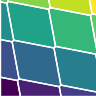

In [17]:
test = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'], all_batches=False, batches=np.arange(41,42))
u.reconstruct_img_from_tensor(test[0][0])

In [18]:
example_X, example_Y = mu.prepare_data(datasize_cut=1, 
                                       param_names=['csd', 'C_DD', 'C_DG'], 
                                       all_batches=False, batches=np.arange(41,42))

print(example_X.shape, example_Y.shape)
print(example_Y[-1])


Original dataset size: 500
Filtered dataset size: 498
Removed 2 datapoints
torch.Size([1, 1, 96, 96]) torch.Size([1, 7])
tensor([ 9.5008,  0.9605, 10.2671,  7.5104,  1.0300,  1.1970,  8.1096])


In [19]:
saliency_overlay, gradcam_overlay, prediction, reconstructed_matrices= mu.explain_output(
    input_tensor=example_X,
    model_name='resnet',
    model_path='./Results/resnet18/resnet18_model_20241028_104258/resnet18_model.pth')

print(prediction)
print(reconstructed_matrices)

d:\!!!_PDF\Fizyka i matma studia\!!!_Leiden\!! projekty 2024_25\Evert van Niewenburg\potencial projects\Qdarts projects\qdarts_code\learning_parameters\utilities\model_utils.py:818: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

[ 9.506121   1.0103334 10.276788   7.5013804  1.0104122  1.0225418
  8.274339 ]
(array([[ 9.50612068,  1.01033342],
       [ 1.01033342, 10.27678776]]), array([[7.5013804, 1.0104122],
       [1.0225418, 8.274339 ]], dtype=float32))


c:\Users\barte\anaconda3\envs\qdarts\lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [20]:
np.abs(np.array(example_Y) -  prediction)

array([[0.00528908, 0.04981083, 0.0097084 , 0.00897312, 0.01954317,
        0.1744256 , 0.16474915]], dtype=float32)

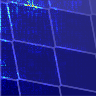

In [21]:
saliency_overlay

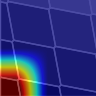

In [22]:
gradcam_overlay

EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[ 9.50612068  1.01033342]
 [ 1.01033342 10.27678776]]
                Dot-gate capacitances: 
                [[7.5013804 1.0104122]
 [1.0225418 8.274339 ]]
                Size of Coulomb peaks V[n] is constant
                


C:\Users\barte\AppData\Local\Temp\ipykernel_36324\1773095794.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


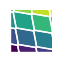

In [24]:
%matplotlib inline
plot, ax = mu.generate_csd_from_prediction(prediction)
plot.show()

### Noise - test

In [2]:
c.set_global_NOISE(True)
c.set_global_S(1)
device = np.array([[1,1]])
c.set_global_N(len(u.get_dots_indices(device)))
c.set_global_K(c.N+c.S)

C_DD, C_DG = u.generate_capacitance_matrices(device)
tunnel_couplings = np.zeros((c.K,c.K))
tunnel_couplings[0,1] = 100*1e-6
tunnel_couplings[1,0] = 100*1e-6

capacitance_config = {
        "C_DD" : C_DD,  #dot-dot capacitance matrix
        "C_Dg" : C_DG,  #dot-gate capacitance matrix
        "ks" : None,       #distortion of Coulomb peaks. NOTE: If None -> constant size of Coublomb peak 
}

tunneling_config = {
        "tunnel_couplings": tunnel_couplings, #tunnel coupling matrix
        "temperature": 0.1,                   #temperature in Kelvin
        "energy_range_factor": 5,  #energy scale for the Hamiltonian generation. NOTE: Smaller -> faster but less accurate computation 
}

sensor_config = {
        "sensor_dot_indices": [2],  #Indices of the sensor dots
        "sensor_detunings": [-0.02],  #Detuning of the sensor dots
        "noise_amplitude": {"fast_noise": 0.8*1e-90, "slow_noise": 2*1e-90}, #Noise amplitude for the sensor dots in eV
        "peak_width_multiplier": 25,  #Width of the sensor peaks in the units of thermal broadening m *kB*T/0.61.
}


In [3]:
experiment = Experiment(capacitance_config=capacitance_config, 
                        tunneling_config=tunneling_config, 
                        sensor_config=sensor_config)

EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[17.3221  2.8175  0.9469]
 [ 2.8175 18.4273  0.5475]
 [ 0.9469  0.5475 43.5638]]
                Dot-gate capacitances: 
                [[6.08790e+00 1.05660e+00 6.89000e-02]
 [1.05660e+00 6.16540e+00 1.98000e-02]
 [6.89000e-02 1.98000e-02 2.30598e+01]]
                Size of Coulomb peaks V[n] is constant
                

            Sensor model deployed with the following parameters:   
            Sensor dot indices: [2]
            Sensor detunings: [-20.] meV
            Coulomb peak width: 0.68 meV
            Slow noise amplitude: 0.0 ueV
            Fast noise amplitude: 0.0 ueV
            

            Tunneling model deployed with the following parameters:
            Tunneling matrix:
            [[0.e+00 1.e-04 0.e+00]
 [1.e-04 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00]]
            Temperature: 0.

In [4]:
# dvmax = -0.01
# dvmin = -0.02
# v0, v1 = np.random.uniform(dvmin, dvmax, 2)

xks, yks, csd_dataks, polytopesks, sensor_signalexp, _ = experiment.generate_CSD(
                                                plane_axes = np.array([[1,0,0],[0,1,0]]), # vectors spanning the cut in voltage space
                                                
                                                target_state = [1,0,5],  # target state for transition
                                                target_transition = [-1,1,0], #target transition from target state, here transition to [2,3,2,3,5,5]

                                                x_voltages=np.linspace(0, 0.05, 500), #voltage range for x-axis
                                                y_voltages=np.linspace(0, 0.05, 500), #voltage range for y-axis
                                                compute_polytopes = True,
                                                # compensate_sensors=True, #compensate the sensors
                                                 #compute the corners of constant occupation
                                                use_sensor_signal=True) #use the sensor signals   



v_offset found: [0.00886564 0.0077072  0.07154017]


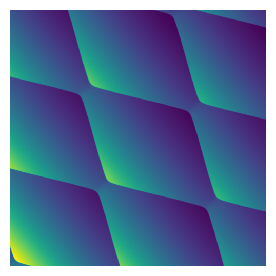

In [5]:
%matplotlib inline
fig, ax = u.plot_CSD(xks, yks, sensor_signalexp[:,:,0], polytopesks)  

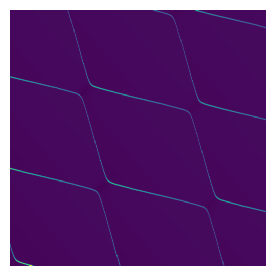

In [6]:
%matplotlib inline
plt.figure(figsize=(c.RESOLUTION/c.DPI, c.RESOLUTION/c.DPI), dpi=c.DPI)
plt.pcolormesh(np.gradient(sensor_signalexp[:,:,0],axis=0))
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [7]:
c.set_global_NOISE(True)
print(c.get_global_S())

x_vol = np.linspace(0, 0.05, 500)
y_vol = np.linspace(0, 0.05, 500)
ks = 0
device = np.array([[1,1]])

c.set_global_S(1)
c.set_global_N(len(u.get_dots_indices(device)))
# c.set_global_K(c.N+c.S)

C_DD, C_DG, ks, cut, x, y, csd, poly, sensor, device = u.generate_dataset(x_vol, y_vol, ks, device)

1
EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[2.64479e+01 5.77300e+00 3.35000e-02]
 [5.77300e+00 5.24080e+01 1.27000e-01]
 [3.35000e-02 1.27000e-01 1.44893e+01]]
                Dot-gate capacitances: 
                [[9.53450e+00 2.16490e+00 1.00000e-04]
 [2.16490e+00 2.10476e+01 1.00000e-03]
 [1.00000e-04 1.00000e-03 7.97610e+00]]
                Size of Coulomb peaks V[n] is constant
                

            Sensor model deployed with the following parameters:   
            Sensor dot indices: [-1]
            Sensor detunings: [-20.] meV
            Coulomb peak width: 0.68 meV
            Slow noise amplitude: 0.0 ueV
            Fast noise amplitude: 0.0 ueV
            

            Tunneling model deployed with the following parameters:
            Tunneling matrix:
            [[0.e+00 1.e-04 1.e-04]
 [1.e-04 0.e+00 1.e-04]
 [1.e-04 1.e-

In [12]:
device = np.array([[1,1]])
len([(x,y) for x,y in zip(np.where(device == 1)[0], np.where(device == 1)[1])])

2

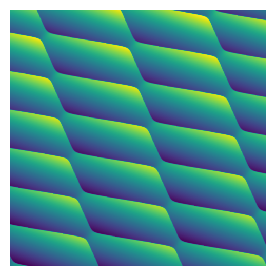

In [8]:
%matplotlib inline
fig, ax = u.plot_CSD(x, y, sensor, poly)  

In [10]:
np.ones((1,2))

array([[1., 1.]])

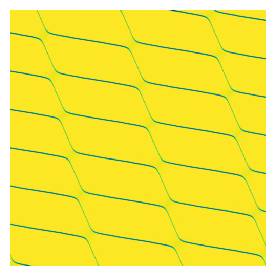

In [9]:
%matplotlib inline
plt.figure(figsize=(c.RESOLUTION/c.DPI, c.RESOLUTION/c.DPI), dpi=c.DPI)
plt.pcolormesh(np.gradient(sensor,axis=0))
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [13]:
cut = np.zeros((2,c.K))
indices = np.random.choice(np.arange(c.N), 2, replace=False)
cut[tuple(zip(*enumerate(indices)))] = 1
cut = cut[np.argmax(cut, axis=1).argsort()] 
    
print(cut)

[[1. 0. 0.]
 [0. 1. 0.]]


### Device

In [23]:
# device = np.array([[0,1, 0,1,0],[1,0,1,0,1],[0,1,0,1,0]])
# device = np.ones((2,2))
# device = np.ones((1,3))
device = np.array([[1,1,0,0,1]])


# r0 = [c.d_DD*np.sqrt(0.5**2+3**2)]
# t0 = [np.arctan(3/0.5)]
r0 = [6*c.d_DD]
t0 = [0]
S=len(t0)
c.set_global_K(len(u.get_dots_indices(device))+S)

sensors = u.set_sensors_positions(S, device, list_r0=r0, list_theta0=t0)
# sensors = u.set_sensors_positions(S, device)

print(device, sensors)

[[1 1 0 0 1]] [(600, 0)]


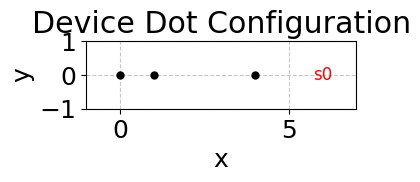

In [24]:
# Example usage:
%matplotlib inline
fig, ax = u.plot_device_lattice(device, sensors)
plt.show()

In [25]:
dist_matrix = u.get_device_distance_matrix(device, sensors)
dist_matrix

array([[  0., 100., 400., 600.],
       [100.,   0., 300., 500.],
       [400., 300.,   0., 200.],
       [600., 500., 200.,   0.]])

In [34]:
C_DD, C_DG = u.exp_decay_model(dist_matrix, model=1)

In [35]:
C_DG

array([[1.03646e+01, 7.15100e-01, 9.00000e-04, 0.00000e+00],
       [7.15100e-01, 5.83480e+00, 9.20000e-03, 1.00000e-04],
       [9.00000e-04, 9.20000e-03, 1.02181e+01, 9.28000e-02],
       [0.00000e+00, 1.00000e-04, 9.28000e-02, 1.11347e+01]])

In [43]:
x= np.ones((c.K,c.K))


array([3., 3., 3.])

In [44]:
C_DD

array([[ 6.9503,  4.6482,  1.5887,  0.5464],
       [ 4.6482,  7.3578,  2.5147,  0.865 ],
       [ 1.5887,  2.5147, 11.3959,  3.9197],
       [ 0.5464,  0.865 ,  3.9197,  7.5529]])

In [45]:
(np.sum(C_DD, axis=1)-np.diag(C_DD))*np.eye(c.K) 


array([[6.7833, 0.    , 0.    , 0.    ],
       [0.    , 8.0279, 0.    , 0.    ],
       [0.    , 0.    , 8.0231, 0.    ],
       [0.    , 0.    , 0.    , 5.3311]])

In [46]:
C_DD + np.sum(C_DG, axis=1).T*np.eye(c.K) + (np.sum(C_DD, axis=1)-np.diag(C_DD))*np.eye(c.K) 

array([[24.8142,  4.6482,  1.5887,  0.5464],
       [ 4.6482, 21.9449,  2.5147,  0.865 ],
       [ 1.5887,  2.5147, 29.74  ,  3.9197],
       [ 0.5464,  0.865 ,  3.9197, 24.1116]])

In [98]:
c.set_global_NOISE(True)
u.generate_capacitance_matrices(device)

(array([[20.1085,  3.8517,  1.3864,  0.6875],
        [ 3.8517, 18.0604,  2.0509,  0.9101],
        [ 1.3864,  2.0509, 21.8335,  2.0483],
        [ 0.6875,  0.9101,  2.0483, 16.7962]]),
 array([[7.4268e+00, 5.9260e-01, 8.0000e-04, 0.0000e+00],
        [5.9260e-01, 4.9495e+00, 7.5000e-03, 2.0000e-04],
        [8.0000e-04, 7.5000e-03, 6.5471e+00, 4.6000e-03],
        [0.0000e+00, 2.0000e-04, 4.6000e-03, 6.0153e+00]]))